<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/Attention_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

# Imports

In [0]:
import torch
import torchtext
import nltk
import random
import spacy
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel

nlp = spacy.load('en')
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Arguments

In [0]:
args = {
    "bert_tokenizer": "bert-base-uncased",
    "bert_pretrained_model": "bert-base-uncased",
    "seed": 1234,
    "bert_embedding_dim": 768,
    "use_glove": True,
    "glove_embedding_dim": 300,
    "max_vocab_size": 20000,
    "batch_size": 64,
    "output_dim": 11,
    "hidden_size": 768,
    "num_layers": 2,
    "dropout": 0.5,
    "fc_dropout": 0.5,
    "embed_dropout": 0.2,
    "weight_decay": 1e-5,
    "lr": 0.001,
    "epochs": 10
}

# Text pre-processor

In [0]:
def preprocessor(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = (re.sub('[\W]+', ' ', text.lower()) +
          ' '.join(emoticons).replace('-', '')) 
  return text

# Setup Bert Tokenizer

In [0]:
tokenizer = BertTokenizer.from_pretrained(args['bert_tokenizer'])

In [0]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_tokenizer']]

print(max_input_length)

512


In [0]:
def tokenize(tweet):
  if (args['use_glove']):
    tweet = tweet.apply(preprocessor)
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

# Load and Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

# GLOVE_DIR = Path(file_path + '/glove/glove.6B.300d.txt')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

if args['use_glove']:
  TEXT = data.Field(batch_first=True,
                    tokenize='spacy',
                    use_vocab=True,
                    sequential=True)
else:
  TEXT = data.Field(batch_first = True,
                use_vocab = False,
                tokenize = tokenize,
                preprocessing = tokenizer.convert_tokens_to_ids,
                init_token = tokenizer.cls_token_id,
                eos_token = tokenizer.sep_token_id,
                pad_token = tokenizer.pad_token_id,
                unk_token = tokenizer.unk_token_id)
  
LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

In [0]:
if args['use_glove']:
  TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300), 
                   max_size=args['max_vocab_size'])
  
print(f"\nUnique tokens in TEXT vocabulary: {len(TEXT.vocab)}")


.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]
.vector_cache/glove.6B.zip:   0%|          | 8.19k/862M [00:01<38:12:29, 6.27kB/s]
.vector_cache/glove.6B.zip:   0%|          | 16.4k/862M [00:01<27:57:33, 8.57kB/s]
.vector_cache/glove.6B.zip:   0%|          | 49.2k/862M [00:01<19:52:28, 12.0kB/s]
.vector_cache/glove.6B.zip:   0%|          | 98.3k/862M [00:01<14:06:46, 17.0kB/s]
.vector_cache/glove.6B.zip:   0%|          | 172k/862M [00:01<10:00:44, 23.9kB/s] 
.vector_cache/glove.6B.zip:   0%|          | 352k/862M [00:01<7:03:43, 33.9kB/s] 
.vector_cache/glove.6B.zip:   0%|          | 713k/862M [00:02<4:58:07, 48.2kB/s]
.vector_cache/glove.6B.zip:   0%|          | 1.43M/862M [00:02<3:29:20, 68.5kB/s]
.vector_cache/glove.6B.zip:   0%|          | 2.88M/862M [00:02<2:26:41, 97.6kB/s]
.vector_cache/glove.6B.zip:   1%|          | 5.39M/862M [00:02<1:42:37, 139kB/s] 
.vector_cache/glove.6B.zip:   1%|          | 8.21M/862M [00:02<1:11:49, 198kB/s]
.vector_cache/glove.6B.zip:   1%|▏         | 1

Unique tokens in TEXT vocabulary: 18645


# Batch Wrapper

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

# Build the Model

Load the pretrained bert model from the HuggingFace transformers library.

https://github.com/huggingface/transformers

In [0]:
bert = BertModel.from_pretrained(args['bert_pretrained_model'])

Use model architecture proposed at: https://www.aclweb.org/anthology/P16-2034/

In [0]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()

    self.attention = nn.Linear(hidden_size, 1)

  def forward(self, H):
    M = torch.tanh(H)
    M = self.attention(M).squeeze(2)
    alpha = F.softmax(M, dim=1).unsqueeze(1)
    return alpha

class AttentionBiLSTM(nn.Module):
  def __init__(self, hidden_size, num_layers, dropout, fc_dropout, 
               emb_layer_dropout, num_classes, use_glove=True):
    super(AttentionBiLSTM, self).__init__()

    self.hidden_size = hidden_size
    self.use_glove = use_glove
    
    if use_glove:
      embedding_dim = args['glove_embedding_dim']
      self.embedding = nn.Embedding(len(TEXT.vocab), embedding_dim)
    else:
      self.bert = bert
      embedding_dim = args['bert_embedding_dim']
    
    # embedding layer dropout
    self.emb_layer_dropout = nn.Dropout(emb_layer_dropout)

    # lstm layer
    self.lstm = nn.LSTM(embedding_dim, 
                        hidden_size, 
                        num_layers, 
                        dropout=(0 if num_layers==1 else dropout),
                        bidirectional=True,
                        batch_first=True)
    
    # penultimate layer
    self.fc = nn.Linear(hidden_size, num_classes)
    self.fc_dropout = nn.Dropout(fc_dropout)
    
    self.attention = Attention(hidden_size)
  
  def forward(self, text):
    if self.use_glove:
      embedded = self.embedding(text)
    else:
      embedded = self.bert(text)[0]

    embedded = self.emb_layer_dropout(embedded)
    y, _ = self.lstm(embedded)
    y = y[:,:,:self.hidden_size] + y[:,:,self.hidden_size:]
    alpha = self.attention(y)
    r = alpha.bmm(y).squeeze(1)
    h = torch.tanh(r)
    logits = self.fc(h)
    logits = self.fc_dropout(logits)
    return logits, alpha 

In [0]:
model = AttentionBiLSTM(
    hidden_size=args['hidden_size'],
    num_layers=args['num_layers'],
    dropout=args['dropout'],
    fc_dropout=args['fc_dropout'],
    emb_layer_dropout=args['embed_dropout'],
    num_classes=args['output_dim'],
)

model

AttentionBiLSTM(
  (embedding): Embedding(18645, 300)
  (emb_layer_dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 768, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=768, out_features=11, bias=True)
  (fc_dropout): Dropout(p=0.5, inplace=False)
  (attention): Attention(
    (attention): Linear(in_features=768, out_features=1, bias=True)
  )
)

Freeze the parameters which are a part of the Bert Transformers model. 

In [0]:
if args['use_glove'] is False:
  for name, param in model.named_parameters():                
      if name.startswith('bert'):
          param.requires_grad = False

Show the trainable parameters.

In [0]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

embedding.weight
lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l0_reverse
lstm.weight_hh_l0_reverse
lstm.bias_ih_l0_reverse
lstm.bias_hh_l0_reverse
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
lstm.weight_ih_l1_reverse
lstm.weight_hh_l1_reverse
lstm.bias_ih_l1_reverse
lstm.bias_hh_l1_reverse
fc.weight
fc.bias
attention.attention.weight
attention.attention.bias


# Train the Model

In [0]:
import torch.optim as optim 

In [0]:
optimizer = optim.Adam(model.parameters(), weight_decay=args['weight_decay'])
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We evaluate using the Jaccard index and the macro and micro F1's as there are more suitable for multi-label text classification problems.

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, jaccard_similarity_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  #acc = roc_auc_score(y, preds)
  acc = jaccard_similarity_score(y, preds.round())

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'acc': acc
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()

    predictions, _ = model(batch.Tweet)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      predictions, _ = model(batch.Tweet)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train the model for 10 epochs and record the training and validation loss. 

In [0]:
best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics = evaluate(model, valid_iterator, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        if args['use_glove']:
          torch.save(model.state_dict(), 'glove-lstm-model.pt')
        else:
          torch.save(model.state_dict(), 'bert-lstm-model.pt')
        

    train_acc = train_metrics['acc']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_acc = valid_metrics['acc']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.583 | Train Acc: 7.08% | Train F1 Micro: 9.13% | Train F1 Macro: 5.58%
	 Val. Loss: 0.500 | Val. Acc: 23.51%  | Val. F1 Micro: 32.71%  | Val. F1 Macro: 16.81%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.555 | Train Acc: 16.18% | Train F1 Micro: 23.63% | Train F1 Macro: 15.51%
	 Val. Loss: 0.460 | Val. Acc: 27.95%  | Val. F1 Micro: 40.39%  | Val. F1 Macro: 29.60%
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.535 | Train Acc: 21.41% | Train F1 Micro: 31.35% | Train F1 Macro: 22.76%
	 Val. Loss: 0.456 | Val. Acc: 31.81%  | Val. F1 Micro: 43.64%  | Val. F1 Macro: 28.21%
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.523 | Train Acc: 23.86% | Train F1 Micro: 34.88% | Train F1 Macro: 25.69%
	 Val. Loss: 0.435 | Val. Acc: 41.58%  | Val. F1 Micro: 53.56%  | Val. F1 Macro: 38.48%
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.515 | Train Acc: 26.12% | Train F1 Micro: 37.65% | Train F1 Macro: 27.20%
	 Val. Loss: 0.433 | Val. Acc: 40.52%  | Val. F1 Micro: 

# Visualize the training and validation loss 

In [0]:
import matplotlib.pyplot as plt

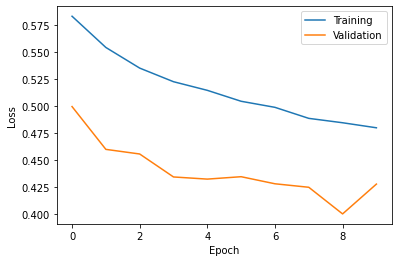

In [0]:
plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

# Assess model performance on testing data

In [0]:
if (args['use_glove']):
  model.load_state_dict(torch.load('glove-lstm-model.pt'))
else:
  model.load_state_dict(torch.load('bert-lstm-model.pt'))


test_loss, test_metrics = evaluate(model, test_iterator, criterion)

test_acc = test_metrics['acc']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.403 | Test Acc: 42.81% | Test F1 Micro: 54.95% | Test F1 Macro: 40.21%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()

  if args['use_glove']:
    tokenized = [token.text for token in nlp.tokenizer(tweet)]
    indexed = [TEXT.vocab.stoi[token] for token in tokenized]
  else:
    tokens = tokenizer.tokenize(tweet)
    tokens = tokens[:max_input_length-2]
    indexed = [tokenizer.cls_token_id] + tokenizer.convert_tokens_to_ids(tokens) + [tokenizer.sep_token_id]

  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions, attn_weights = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())

  if args['use_glove']:
    return preds, attn_weights, tokenized
  else:
    return preds, attn_weights, tokens

Lets test the model on our own input and save the attention weights and tokens for visualization. 

In [0]:
preds, attn_weights, tokens = predict_emotion(model, tokenizer, 
                                              "Good music, I love that shit.")

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]}")

ANGER: 0.4289329946041107
ANTICIPATION: 0.06619147956371307
DISGUST: 0.34612202644348145
FEAR: 0.16293853521347046
JOY: 0.7913063764572144
LOVE: 0.943019688129425
OPTIMISM: 0.3545425236225128
PESSIMISM: 0.23751763999462128
SADNESS: 0.3466644287109375
SURPRISE: 0.0287922453135252
TRUST: 0.1873425543308258


Here we format the attention weights and store the results in a dictionary

In [0]:
aws = []
for a in attn_weights[0]:
  for v in a:
    aws.append(v.detach().cpu().numpy())

if args['use_glove']:
  aws = np.array(aws)
else:
  aws = aws[1:-1]
  aws = np.array(aws)

aws

array([0.07172969, 0.08617017, 0.01449907, 0.00758499, 0.6115376 ,
       0.02783199, 0.16574356, 0.01490299], dtype=float32)

In [0]:
attn_dict = {}
for i in range(len(aws)):
  attn_dict[tokens[i]] = aws[i]

print(attn_dict)

{'Good': 0.07172969, 'music': 0.08617017, ',': 0.014499074, 'I': 0.007584992, 'love': 0.6115376, 'that': 0.02783199, 'shit': 0.16574356, '.': 0.014902992}


Lets return the top 3 words that the model focused on. 

In [0]:
from collections import Counter

In [0]:
Counter(attn_dict).most_common(3)

[('love', 0.6115376), ('shit', 0.16574356), ('music', 0.08617017)]